In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

In [22]:
def load_data(filepath):
    """Safely load data from CSV, handling common errors."""
    try:
        data = pd.read_csv(filepath)
        if data.empty:
            print(f"Warning: {filepath} is empty.")
            return None
        return data
    except FileNotFoundError:
        print(f"Error: File {filepath} not found.")
        return None
    except pd.errors.EmptyDataError:
        print(f"Error: File {filepath} is empty, no data to load.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None



def calculate_percentage(data):
    """Calculate percentage of significant changes in electrode data."""
    # Check if the input data is valid (not None or empty)
    if data is None:
        return None, None

    total_electrodes = len(data)  # Total number of electrodes used in paper

    # Calculate the number of significant increases based on p-value and PSC
    sig_increases = data[(data['p-value'] <= 0.05) & (data['PSC'] > 0)].shape[0]

    # Calculate the number of significant decreases based on p-value and PSC
    sig_decreases = data[(data['p-value'] <= 0.05) & (data['PSC'] <= 0)].shape[0]

    # Calculate the percentage of significant increases
    increase_percent = (sig_increases / total_electrodes) * 100

    # Calculate the percentage of significant decreases
    decrease_percent = (sig_decreases / total_electrodes) * 100

    return increase_percent, decrease_percent  # Return the calculated percentages


def calculate_significant_changes_percentage_by_type(data):
    """Calculates the percentage of electrodes showing significant changes by frequency type."""

    # Check if the input data is valid (not None or empty)
    if data is None:
        print("No data provided or data is empty.")
        return None

    # Get the total number of electrodes
    total_electrodes = len(data)
    # Initialize a dictionary to store counts for each category (significant and non-significant changes)
    results = {'sig_pos': 0, 'sig_neg': 0, 'non_sig_pos': 0, 'non_sig_neg': 0}

    # Define the 'p-value' and 'PSC' columns
    required_columns = {'p-value', 'PSC'}
    # Check if the data contains the necessary columns
    if not required_columns.issubset(data.columns):
        print(f"Data is missing required columns. Required: {required_columns}")
        return None

    # Loop through each row in the data to classify and count changes based on p-value and PSC
    for _, row in data.iterrows():
        # If the p-value is 0.05 or less and the Percent Signal Change (PSC) is non-negative,
        # it's considered a significant positive change.
        if row['p-value'] <= 0.05 and row['PSC'] >= 0:
            results['sig_pos'] += 1
        # If the p-value is 0.05 or less and the PSC is negative,
        # it's considered a significant negative change.
        elif row['p-value'] <= 0.05 and row['PSC'] < 0:
            results['sig_neg'] += 1
        # If the p-value is greater than 0.05 and the PSC is non-negative,
        # it's considered a non-significant positive change.
        elif row['p-value'] > 0.05 and row['PSC'] >= 0:
            results['non_sig_pos'] += 1
        # If the p-value is greater than 0.05 and the PSC is negative,
        # it's considered a non-significant negative change.
        elif row['p-value'] > 0.05 and row['PSC'] < 0:
            results['non_sig_neg'] += 1

    # Calculate the percentage of each category by dividing the count by the total number of electrodes
    # and multiplying by 100 to get a percentage.
    for key in results:
        results[key] = (results[key] / total_electrodes) * 100

    return results


def calculate_electrode_counts_networks(data):
    """Calculates the percentage of electrodes for specified power changes across networks."""

    # Check if the input data is None or empty
    if data is None or data.empty:
        # If data is empty or None, return default values for each network type
        return {'fpn_increase': 0, 'fpn_decrease': 0, 'non_fpn_increase': 0, 'non_fpn_decrease': 0}

    # Filter the data to only include rows where the p-value is less than or equal to 0.051 (significant data)
    sig_data = data[data['p-value'] <= 0.05]

    # Calculate the total number of significant electrodes
    total_sig = len(sig_data)

    # List of non-FPN networks
    non_fpn_networks = ['DMN', 'CON', 'motor']

    # Initialize a dictionary to store the results of percentage calculations for each category
    results = {
        # Calculate percentage of FPN electrodes with significant increase in power
        'fpn_increase': (len(sig_data[(sig_data['Network'] == 'FPN') & (sig_data['PSC'] >= 0)]) / total_sig) * 100 if total_sig > 0 else 0,

        # Calculate percentage of FPN electrodes with significant decrease in power
        'fpn_decrease': (len(sig_data[(sig_data['Network'] == 'FPN') & (sig_data['PSC'] < 0)]) / total_sig) * 100 if total_sig > 0 else 0,

        # Calculate percentage of non-FPN electrodes (e.g. DMN, CON, motor) with significant increase in power
        'non_fpn_increase': (len(sig_data[(sig_data['Network'].isin(non_fpn_networks)) & (sig_data['PSC'] > 0)]) / total_sig) * 100 if total_sig > 0 else 0,

        # Calculate percentage of non-FPN electrodes (e.g. DMN, CON, motor) with significant decrease in power
        'non_fpn_decrease': (len(sig_data[(sig_data['Network'].isin(non_fpn_networks)) & (sig_data['PSC'] < 0)]) / total_sig) * 100 if total_sig > 0 else 0,
    }

    # Return the results as a dictionary with percentage values for each category
    return results


def calculate_net_changes(data):
    """Calculate net changes for significant electrodes by network and band."""
    # Categorize each electrode into 'FPN' or 'non-FPN' based on the 'Network' column.
    # This uses a lambda function to check if 'FPN' is part of the network name.
    data['Network Type'] = data['Network'].apply(lambda x: 'FPN' if 'FPN' in x else 'non-FPN')

    # Filter data to include only rows where the p-value indicates significance (p < 0.05).
    sig_data = data[data['p-value'] < 0.05]

    # Initialize a dictionary to store the results.
    results = {}

    # Group the significant data by 'Network Type' and 'Band', then iterate over each group.
    for (network, band), group in sig_data.groupby(['Network Type', 'Band']):
        # Calculate the average increase in PSC where the PSC is positive.
        # If there are no positive PSC values, default to 0.
        increase_avg = group[group['PSC'] > 0]['PSC'].mean() if not group[group['PSC'] > 0]['PSC'].empty else 0

        # Calculate the average decrease in PSC where the PSC is negative.
        # If there are no negative PSC values, default to 0.
        decrease_avg = group[group['PSC'] < 0]['PSC'].mean() if not group[group['PSC'] < 0]['PSC'].empty else 0

        # Calculate net change as the sum of the average increase and decrease.
        net_change = increase_avg + decrease_avg

        # Store the net change in the results dictionary under the appropriate network and band.
        results.setdefault(network, {})[band] = net_change

    # Return the results dictionary containing net changes for all significant electrodes
    # categorized by network type and band.
    return results


def calculate_average_changes(data):
    """Calculate the average changes for significant electrodes per network across all bands."""
    # Filter the data to include only rows where the p-value is less than 0.05 (indicating significance)
    data = data[data['p-value'] < 0.05]

    # Check if the filtered data is not empty to proceed with the calculation.
    if not data.empty:
        # Group the significant data by the 'Network' column and calculate the mean of the 'PSC' values for each network
        return data.groupby('Network')['PSC'].mean().reset_index()
        # The reset_index() function is used to transform the resulting Series into a DataFrame and provide
        # a clean index. This DataFrame will have two columns: 'Network' and the average 'PSC'.

    # If the filtered data is empty return an empty DataFrame  with the columns 'Network' and 'PSC'.
    return pd.DataFrame(columns=['Network', 'PSC'])


In [15]:
# Loading data
data_hg = load_data('Band5-HG Results - Band5-HG Results.csv')
data_lg = load_data('Band4-Gamma Results - Band4-Gamma Results.csv')
data_beta = load_data('Band3-Beta Results - Band3-Beta Results.csv')
data_alpha = load_data('Band2-Alpha Results - Band2-Alpha Results.csv')
data_theta = load_data('Band1-Theta Results - Band1-Theta Results.csv')
data_delta = load_data('Band0-Delta Results - Band0-Delta Results.csv')

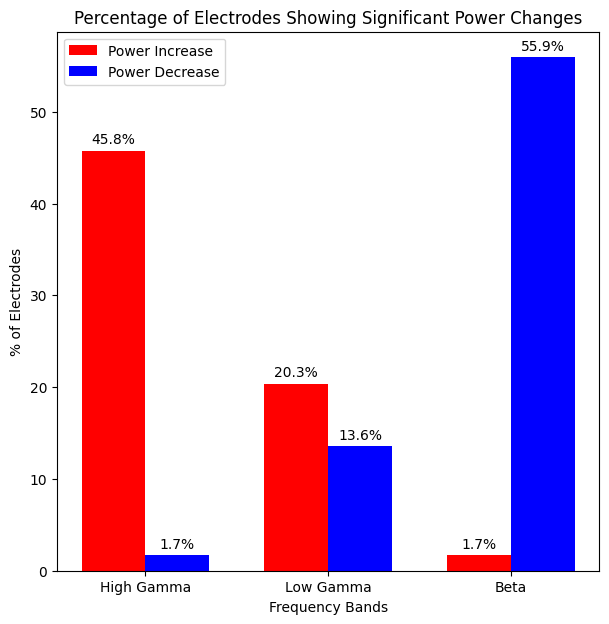

In [16]:
# Ensurig all datasets are properly loaded and processed
if data_hg is not None and data_lg is not None and data_beta is not None:
    # Calculating percentages
    hg_inc_percent, hg_dec_percent = calculate_percentage(data_hg)
    lg_inc_percent, lg_dec_percent = calculate_percentage(data_lg)
    beta_inc_percent, beta_dec_percent = calculate_percentage(data_beta)

    # If none of the inc/dec dataframes is None, enter here
    if None not in (hg_inc_percent, hg_dec_percent, lg_inc_percent, lg_dec_percent, beta_inc_percent, beta_dec_percent):

        # Plotting
        fig, ax = plt.subplots(figsize=(7,7))
        categories = ['High Gamma', 'Low Gamma', 'Beta']
        increases = [hg_inc_percent, lg_inc_percent, beta_inc_percent]
        decreases = [hg_dec_percent, lg_dec_percent, beta_dec_percent]

        index = range(len(categories))
        bar_width = 0.35

        bars1 = ax.bar(index, increases, bar_width, label='Power Increase', color='red')
        bars2 = ax.bar([i + bar_width for i in index], decreases, bar_width, label='Power Decrease', color='blue')

        # Adding value labels
        for bar in bars1 + bars2:
            height = bar.get_height()
            ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                        textcoords="offset points", ha='center', va='bottom')

        ax.set_xlabel('Frequency Bands')
        ax.set_ylabel('% of Electrodes')
        ax.set_title('Percentage of Electrodes Showing Significant Power Changes')
        ax.set_xticks([i + bar_width / 2 for i in index])
        ax.set_xticklabels(categories)
        ax.legend()

        plt.show()
    else:
        print("Calculation error: Could not compute percentages for one or more bands.")
else:
    print("Error: Data loading failed for one or more bands.")


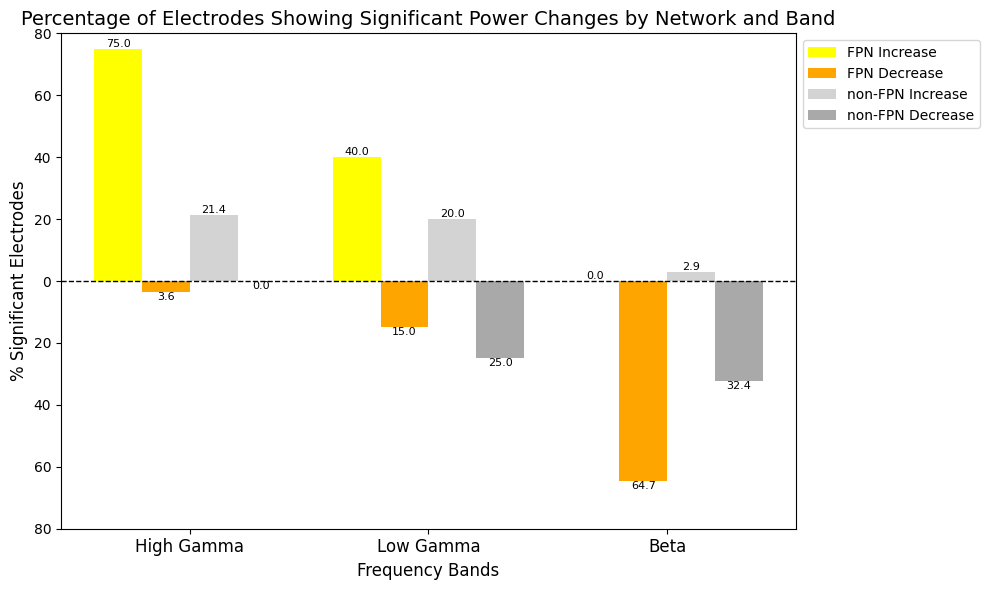

In [17]:
# Calculating data
results_hg = calculate_electrode_counts_networks(data_hg)
results_lg = calculate_electrode_counts_networks(data_lg)
results_beta = calculate_electrode_counts_networks(data_beta)

# Preparing data for plotting
categories = ['High Gamma', 'Low Gamma', 'Beta']
results_list = [results_hg, results_lg, results_beta]
index = np.arange(len(categories))
bar_width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['yellow', 'orange', 'lightgrey', 'darkgrey']
labels = ['FPN Increase', 'FPN Decrease', 'non-FPN Increase', 'non-FPN Decrease']

# Plotting bars with proper alignment
for i, results in enumerate(results_list):
    for j, label in enumerate(labels):
        key = label.lower().replace(" ", "_").replace("-", "_")
        value = results.get(key, 0)  # Retrieve correct value
        offset = index[i] + (j - 1.5) * bar_width  # Proper bar alignment

        # Plotting bar
        ax.bar(offset, value if 'increase' in key else -value, bar_width, color=colors[j], label=label if i == 0 else "")

        # Adding value label above and below bar
        ax.text(offset,
                value if 'increase' in key else -value,
                f'{value:.1f}',
                ha='center', va='bottom' if 'increase' in key else 'top',
                fontsize=8)

# Plot configuration
ax.set_xlabel('Frequency Bands', fontsize=12)
ax.set_ylabel('% Significant Electrodes', fontsize=12)
ax.set_title('Percentage of Electrodes Showing Significant Power Changes by Network and Band', fontsize=14)
ax.set_xticks(index)
ax.set_xticklabels(categories, fontsize=12)
ax.axhline(0, color='black', linewidth=1, linestyle='--')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
ax.set_ylim(-80, 80)
ax.set_yticks(range(-80, 81, 20))
ax.set_yticklabels([abs(tick) for tick in range(-80, 81, 20)])


plt.tight_layout()
plt.show()


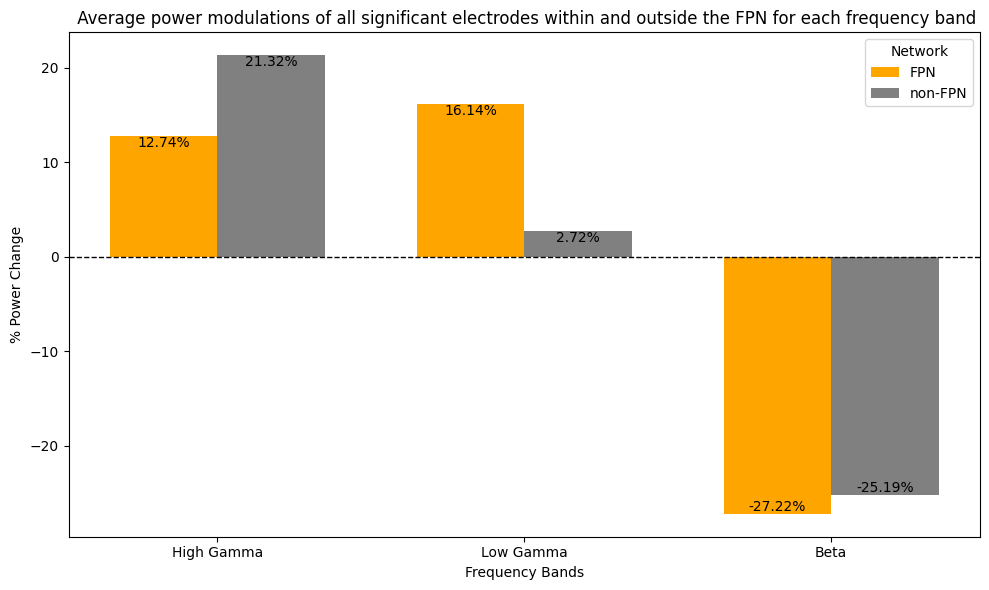

In [18]:
# Loading and preparing data
data_hg = load_data('Band5-HG Results - Band5-HG Results.csv')
data_hg['Band'] = 'High Gamma'
data_lg = load_data('Band4-Gamma Results - Band4-Gamma Results.csv')
data_lg['Band'] = 'Low Gamma'
data_beta = load_data('Band3-Beta Results - Band3-Beta Results.csv')
data_beta['Band'] = 'Beta'

# Combining and calculating net changes
combined_data = pd.concat([data_hg, data_lg, data_beta])
net_changes = calculate_net_changes(combined_data)

# Plotting net changes with value
fig, ax = plt.subplots(figsize=(10, 6))
colors = {'FPN': 'orange', 'non-FPN': 'grey'}
bands = ['High Gamma', 'Low Gamma', 'Beta']
network_types = ['FPN', 'non-FPN']

for i, band in enumerate(bands):
    for j, network in enumerate(network_types):
        value = net_changes.get(network, {}).get(band, 0)
        bar = ax.bar(i + j * 0.35, value, 0.35, color=colors[network], label=f'{network}' if i == 0 else '')
        ax.text(bar[0].get_x() + bar[0].get_width() / 2, bar[0].get_height(),
                f'{value:.2f}%', ha='center', va='bottom' if value < 0 else 'top')

ax.set_ylabel('% Power Change')
ax.set_xlabel('Frequency Bands')
ax.set_title(' Average power modulations of all significant electrodes within and outside the FPN for each frequency band')
ax.set_xticks(np.arange(len(bands)) + 0.35 / 2)
ax.set_xticklabels(bands)
ax.legend(title='Network')
ax.axhline(0, color='black', linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()


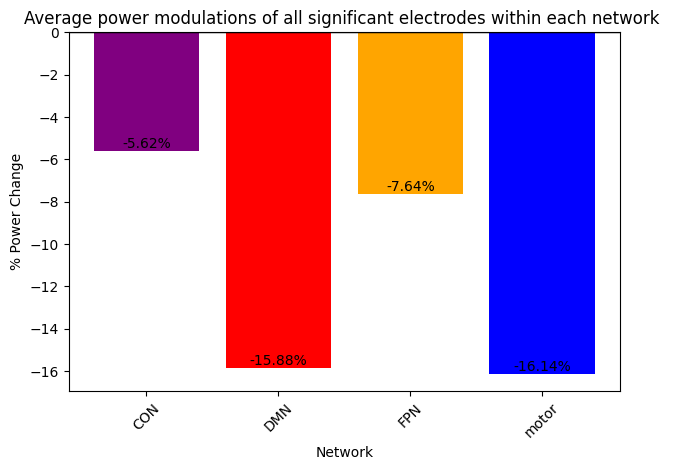

In [23]:
# Color mapping for each network
color_map = {
    'FPN': 'orange',
    'DMN': 'red',
    'CON': 'purple',
    'motor': 'blue'
}

combined_data = pd.concat([
    data_hg,
    data_lg,
    data_beta,
    data_alpha,
    data_theta,
    data_delta
])


# Average changes
network_changes = calculate_average_changes(combined_data)

# Plotting
fig, ax = plt.subplots()
networks = network_changes['Network']
values = network_changes['PSC']

# Colors to each network
colors = [color_map[network] if network in color_map else 'gray' for network in networks]

bars = ax.bar(networks, values, color=colors)
ax.axhline(0, color='black', linewidth=1)

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, value, f'{value:.2f}%', ha='center', va='bottom' if value < 0 else 'top')

ax.set_xlabel('Network')
ax.set_ylabel('% Power Change')
ax.set_title('Average power modulations of all significant electrodes within each network ')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


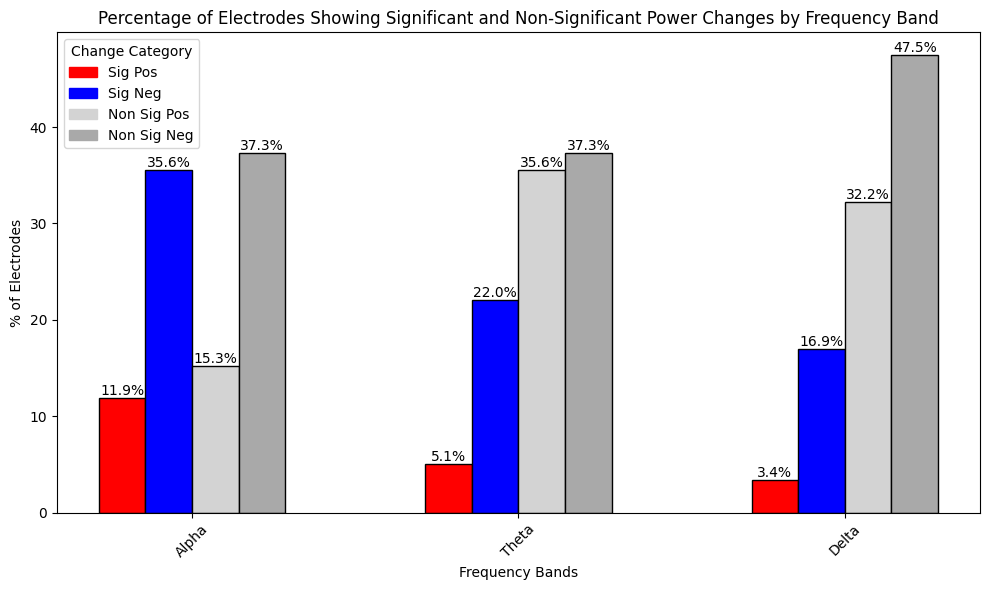

In [ ]:
results_alpha = calculate_significant_changes_percentage_by_type(data_alpha)
results_theta = calculate_significant_changes_percentage_by_type(data_theta)
results_delta = calculate_significant_changes_percentage_by_type(data_delta)

categories = ['sig_pos', 'sig_neg', 'non_sig_pos', 'non_sig_neg']
frequencies = ['Alpha', 'Theta', 'Delta']
results = {'Alpha': results_alpha, 'Theta': results_theta, 'Delta': results_delta}

category_colors = {
    'sig_pos': 'red',
    'sig_neg': 'blue',
    'non_sig_pos': 'lightgrey',
    'non_sig_neg': 'darkgrey'
}

fig, ax = plt.subplots(figsize=(10, 6))

# Spacing between groups
group_width = len(categories) * 0.2
extra_space = 0.5  # Space between groups
group_starts = np.array([0, 1, 2]) * (group_width + extra_space + 0.1)  # Adjusted for better visual separation

for i, freq in enumerate(frequencies):
    offsets = group_starts[i] + np.arange(len(categories)) * 0.2
    percentages = [results[freq][cat] for cat in categories]
    colors = [category_colors[cat] for cat in categories]
    bars = ax.bar(offsets, percentages, 0.2, color=colors, edgecolor='black')

    # Percentage values on top of each bar
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}%', ha='center', va='bottom')

ax.set_title('Percentage of Electrodes Showing Significant and Non-Significant Power Changes by Frequency Band')
ax.set_xlabel('Frequency Bands')
ax.set_ylabel('% of Electrodes')

# Legend to reflect the types of changes
legend_elements = [plt.Rectangle((0,0),1,1, color=category_colors[cat], label=cat.replace('_', ' ').title()) for cat in categories]
ax.legend(handles=legend_elements, title='Change Category')

ax.set_xticks(group_starts + 1.5 * 0.2)
ax.set_xticklabels(frequencies)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
